# Clasificación de Edad con Visión Artificial — Proyecto Good Seed

Este proyecto tiene como objetivo desarrollar un modelo de aprendizaje profundo que determine la edad aproximada de una persona a partir de una fotografía. La cadena de supermercados **Good Seed** busca implementar esta tecnología en sus tiendas para **prevenir la venta de alcohol a menores de edad**, cumpliendo con las regulaciones legales.


## Inicialización

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
# Carar imagenes 

train_datagen = ImageDataGenerator(rescale = 1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224,224),
    batch_size = 32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


## EDA

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.median()

real_age    29.0
dtype: float64

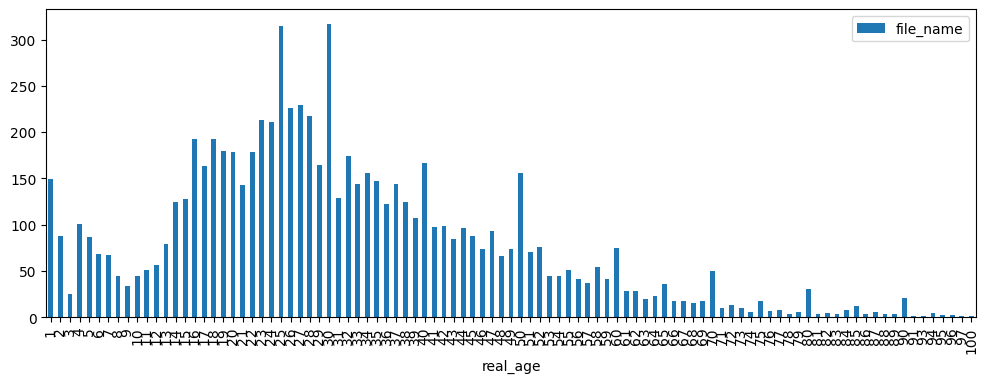

In [ ]:
# Numero de fotos por edad
labels.groupby('real_age').count().plot(kind='bar',figsize=(12,4))
plt.show()

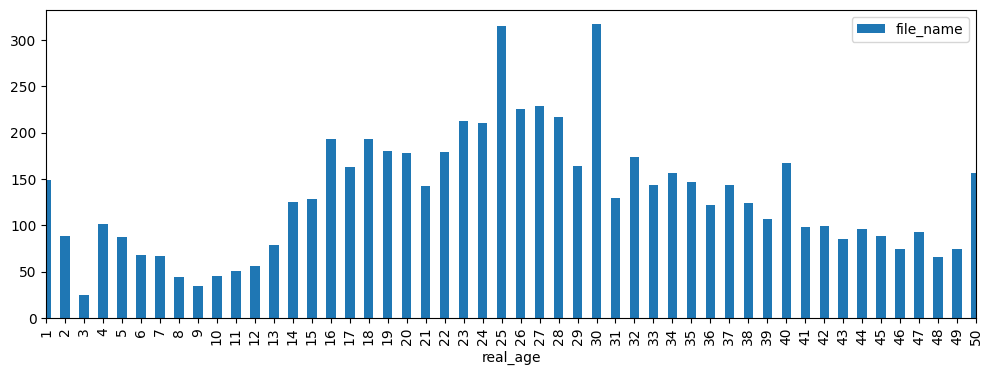

In [ ]:
# Numero de fotos por edades menores a 50
labels.groupby('real_age').count().plot(kind='bar',figsize=(12,4))
plt.xlim(0,49)
plt.show()

* La media y la mediana de las edades es aproximadamente 31 y 29 años respectivamente.
* El minimo y maximo de edades es desde 1 a 100 años
* 25% de los datos corresponden a personas menores de 20 años
* 75% de los datos corresponden a personas menores de 49 años 

In [ ]:
features, target = next(train_gen_flow)

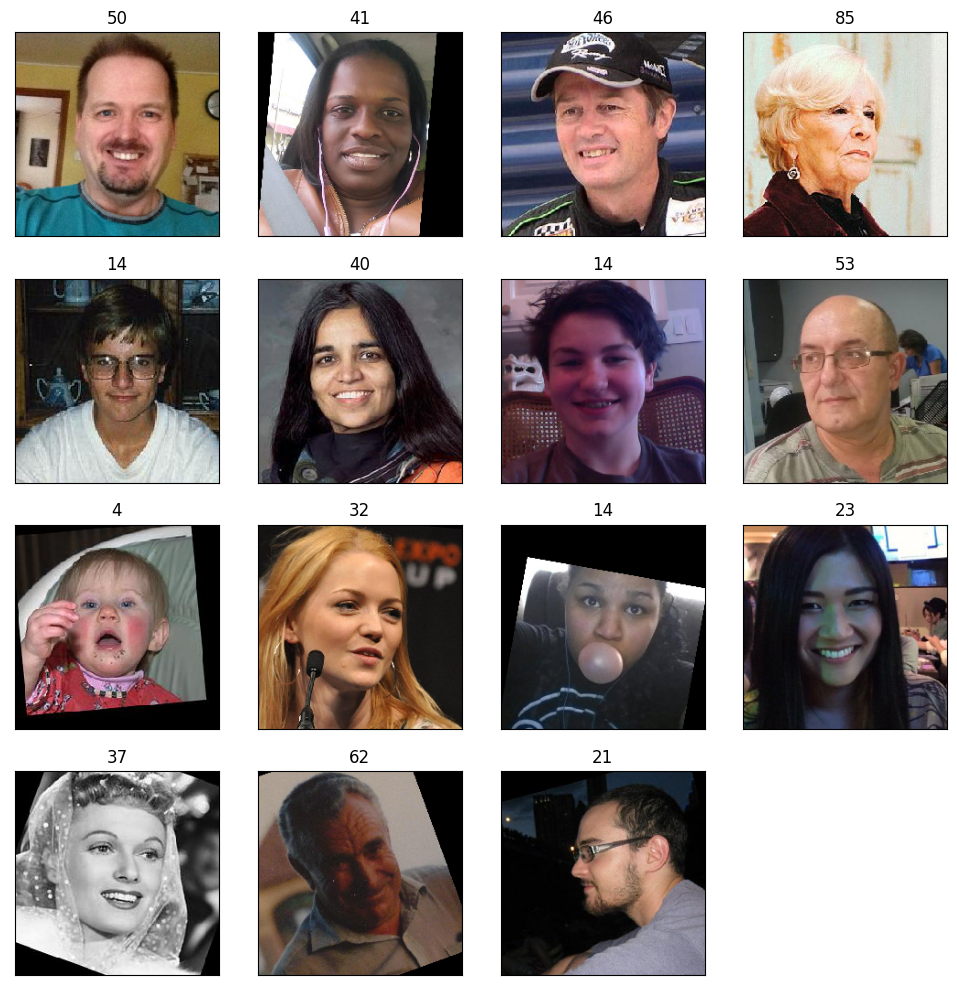

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(15):
    fig.add_subplot(4,4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusiones

Dado a que el objetivo del análisis es identificar personas consideradas adultas, la limitada información sobre individuos mayores de 40 años no representa un impacto significativo, ya que el 80% de los datos corresponde a personas de mas de 20 años. 

Sin embargo, solo el 25% de los datos pertenece a individuos menores de 20 años, lo que indica una escasez de información sobre este grupo. Dado que la precensia de menores es crucial para el propósito del modelo, esta falta de datos podría afectar su capacidad de clasificación y precisión en este rango de edad.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(path + 'labels.csv')

    data_datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2
    )

    train_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size=32,
        class_mode = 'raw',
        subset = 'training', 
        seed = 12345
    )

    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(rescale = 1./225, validation_split = 0.25)

    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path+'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(
        weights = 'imagenet',
        input_shape = input_shape,
        include_top = False
    ) 

    model = Sequential()
    model.add(backbone) 
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None: 
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data = test_data,
        batch_size = batch_size,
        epochs = epochs,
        steps_per_epoch = steps_per_epoch,
        validation_steps = validation_steps,
        verbose = 2
    )
    
    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

GPU platform output:

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 65s - loss: 245.0955 - mae: 11.1823 - val_loss: 894.1795 - val_mae: 25.0574

Epoch 2/20
178/178 - 38s - loss: 62.5884 - mae: 6.0004 - val_loss: 947.6217 - val_mae: 25.9671

Epoch 3/20
178/178 - 38s - loss: 31.7947 - mae: 4.2828 - val_loss: 331.6021 - val_mae: 13.3702

Epoch 4/20
178/178 - 38s - loss: 19.6925 - mae: 3.4174 - val_loss: 109.8431 - val_mae: 8.0275

Epoch 5/20
178/178 - 38s - loss: 14.7646 - mae: 2.9938 - val_loss: 86.0103 - val_mae: 6.9398

Epoch 6/20
178/178 - 38s - loss: 12.7118 - mae: 2.7601 - val_loss: 70.8739 - val_mae: 6.3532

Epoch 7/20
178/178 - 38s - loss: 10.9120 - mae: 2.5098 - val_loss: 71.6178 - val_mae: 6.5183

Epoch 8/20
178/178 - 38s - loss: 8.4091 - mae: 2.2008 - val_loss: 70.8441 - val_mae: 6.4877

Epoch 9/20
178/178 - 38s - loss: 7.1094 - mae: 2.0067 - val_loss: 70.6308 - val_mae: 6.3671

Epoch 10/20
178/178 - 38s - loss: 7.0045 - mae: 1.9915 - val_loss: 65.9421 - val_mae: 6.2099

Epoch 11/20
178/178 - 38s - loss: 6.7090 - mae: 1.9431 - val_loss: 76.8608 - val_mae: 6.6062

Epoch 12/20
178/178 - 38s - loss: 6.5722 - mae: 1.9482 - val_loss: 65.8247 - val_mae: 6.0685

Epoch 13/20
178/178 - 38s - loss: 5.8667 - mae: 1.8191 - val_loss: 66.8528 - val_mae: 6.3149

Epoch 14/20
178/178 - 38s - loss: 5.2492 - mae: 1.7317 - val_loss: 68.5052 - val_mae: 6.1672

Epoch 15/20
178/178 - 38s - loss: 5.3717 - mae: 1.7398 - val_loss: 64.1595 - val_mae: 6.0654

Epoch 16/20
178/178 - 38s - loss: 5.4877 - mae: 1.7399 - val_loss: 74.2116 - val_mae: 6.4131

Epoch 17/20
178/178 - 39s - loss: 5.2340 - mae: 1.7160 - val_loss: 75.5454 - val_mae: 6.7340

Epoch 18/20
178/178 - 38s - loss: 5.5712 - mae: 1.7661 - val_loss: 64.6718 - val_mae: 6.0515

Epoch 19/20
178/178 - 38s - loss: 5.9201 - mae: 1.8039 - val_loss: 65.5080 - val_mae: 6.1561

Epoch 20/20
178/178 - 38s - loss: 5.5354 - mae: 1.7689 - val_loss: 68.3448 - val_mae: 6.1393

60/60 - 9s - loss: 68.3448 - mae: 6.1393

Test MAE: 6.1393

## Conclusiones

El modelo ha mostrado una mejora progresiva en la reducción de la pérdida y el error absoluto medio a lo largo de 20 épocas de entrenamiento. En las primeras etapas, los valores de loss y MAE eran significativamente altos, lo que indicaba una gran diferencia entre las predicciones del modelo y los valores reales. Sin embargo, a medida que avanzaba el entrenamiento, estos valores disminuyeron gradualmente, lo que sugiere que el modelo fue aprendiendo patrones más efectivos. 

Un aspecto importante a considerar es la coposición del conjunto de datos. La mayoria de las imágenes corresponden a personas de entre 29 y 31 años, mientras que solo el 25% del conjunto representan a menores de 20 años, quienes son el grupo de interés en el análisis. Esta distribución sesgada podría afectar la capacidad del modelo para generalizar correctamente hacia la población objetivo. 